## **Classificação do Risco de Fogo no município de Altamira- PA**

---
&nbsp;

> #### A **Parte 2** desse projeto corresponde à fase de Análise exploratória até a criação dos modelos de Classificação de Machine Learning

### Importação de bibliotecas

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import svm
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics
from scipy.stats import normaltest
from scipy import stats
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from skopt import BayesSearchCV
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

### DataFrame utilizado

In [2]:
df =  pd.read_csv("df_result.csv")

df.head()

,Data,Hora (UTC),DiaSemChuva,Precipitacao,Latitude,Longitude,Temp. Ins. (C),Temp. Max. (C),Temp. Min. (C),Umi. Ins. (%),...,Pto Orvalho Max. (C),Pto Orvalho Min. (C),Pressao Ins. (hPa),Pressao Max. (hPa),Pressao Min. (hPa),Vel. Vento (m/s),Dir. Vento (m/s),Raj. Vento (m/s),Chuva (mm),ClassificacaoRF
0,26/07/2019,22,44.0,0.0,-7.74,-54.83,28.2,29.5,28.2,68.0,...,22.1,21.7,990.6,990.6,990.2,0.5,115.0,1.7,0.0,alto
1,26/07/2019,22,45.0,0.0,-7.75,-54.82,28.2,29.5,28.2,68.0,...,22.1,21.7,990.6,990.6,990.2,0.5,115.0,1.7,0.0,alto
2,26/07/2019,20,43.0,0.0,-7.77,-54.84,30.4,31.2,30.4,56.0,...,21.6,20.4,989.7,989.7,989.5,1.7,82.0,5.6,0.0,alto
3,03/08/2019,23,29.0,0.0,-8.27,-54.85,27.3,28.5,27.3,73.0,...,22.1,21.3,990.0,990.0,989.5,0.2,167.0,1.0,0.0,alto
4,03/08/2019,23,30.0,0.0,-8.27,-54.81,27.3,28.5,27.3,73.0,...,22.1,21.3,990.0,990.0,989.5,0.2,167.0,1.0,0.0,alto


In [3]:
#quantidade de linhas e colunas
df.shape

(7497, 23)

In [4]:
#visualização das classificações
df['ClassificacaoRF'].value_counts()

ClassificacaoRF
alto     6193
médio     706
baixo     598
Name: count, dtype: int64

In [5]:
df.columns

Index(['Data', 'Hora (UTC)', 'DiaSemChuva', 'Precipitacao', 'Latitude',
       'Longitude', 'Temp. Ins. (C)', 'Temp. Max. (C)', 'Temp. Min. (C)',
       'Umi. Ins. (%)', 'Umi. Max. (%)', 'Umi. Min. (%)',
       'Pto Orvalho Ins. (C)', 'Pto Orvalho Max. (C)', 'Pto Orvalho Min. (C)',
       'Pressao Ins. (hPa)', 'Pressao Max. (hPa)', 'Pressao Min. (hPa)',
       'Vel. Vento (m/s)', 'Dir. Vento (m/s)', 'Raj. Vento (m/s)',
       'Chuva (mm)', 'ClassificacaoRF'],
      dtype='object')

In [6]:
# Todos as colunas com valores Instantâneos serão removidas, já que estamos utilizando dados da hora do foco do incêndio e não do momento exato
df.drop(columns=['Temp. Ins. (C)', 'Umi. Ins. (%)', 'Pto Orvalho Ins. (C)', 'Pressao Ins. (hPa)'], inplace=True)

df.head()

,Data,Hora (UTC),DiaSemChuva,Precipitacao,Latitude,Longitude,Temp. Max. (C),Temp. Min. (C),Umi. Max. (%),Umi. Min. (%),Pto Orvalho Max. (C),Pto Orvalho Min. (C),Pressao Max. (hPa),Pressao Min. (hPa),Vel. Vento (m/s),Dir. Vento (m/s),Raj. Vento (m/s),Chuva (mm),ClassificacaoRF
0,26/07/2019,22,44.0,0.0,-7.74,-54.83,29.5,28.2,69.0,63.0,22.1,21.7,990.6,990.2,0.5,115.0,1.7,0.0,alto
1,26/07/2019,22,45.0,0.0,-7.75,-54.82,29.5,28.2,69.0,63.0,22.1,21.7,990.6,990.2,0.5,115.0,1.7,0.0,alto
2,26/07/2019,20,43.0,0.0,-7.77,-54.84,31.2,30.4,59.0,53.0,21.6,20.4,989.7,989.5,1.7,82.0,5.6,0.0,alto
3,03/08/2019,23,29.0,0.0,-8.27,-54.85,28.5,27.3,73.0,65.0,22.1,21.3,990.0,989.5,0.2,167.0,1.0,0.0,alto
4,03/08/2019,23,30.0,0.0,-8.27,-54.81,28.5,27.3,73.0,65.0,22.1,21.3,990.0,989.5,0.2,167.0,1.0,0.0,alto


#### Visualização dos riscos de incêndios ao longo dos anos de 2019 e 2020 em determinada área

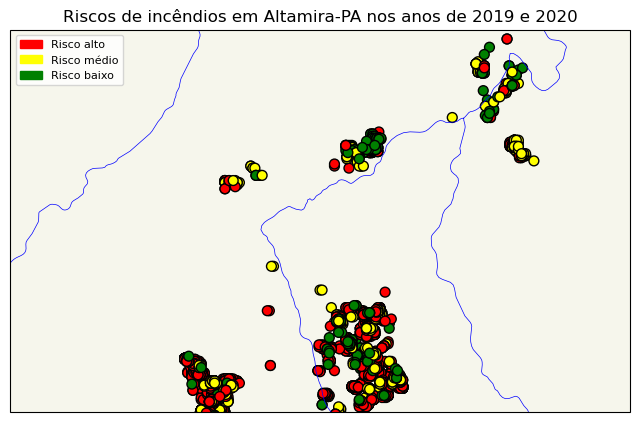

In [7]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.patches as mpatches


# Definir cores para os rótulos
color_map = {'alto': 'red', 'médio': 'yellow', 'baixo': 'green'}
colors = df['ClassificacaoRF'].map(color_map)

# Criar o mapa com projeção geográfica
fig, ax = plt.subplots(figsize=(8, 6), subplot_kw={'projection': ccrs.PlateCarree()})

# Ajustar a área para Altamira (Pará)
ax.set_extent([-57, -51, -6.7, -3])

# Adicionar recursos ao mapa
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAND, edgecolor='black', alpha=0.5)
ax.add_feature(cfeature.RIVERS, edgecolor='blue', linewidth=0.5)

# Plotar os pontos no mapa
ax.scatter(df['Longitude'], df['Latitude'], c=colors, s=50, edgecolors='black')

handles = [mpatches.Patch(color=color_map[label], label=f"Risco {label}") for label in color_map]
ax.legend(handles=handles, loc="upper left", fontsize=8)

# Exibir o mapa
plt.title("Riscos de incêndios em Altamira-PA nos anos de 2019 e 2020")
plt.show()

#### Retornando à análise

In [8]:
#Excluindo as colunas de longitude e LAtitude, já que não serão úteis para a classificação
df = df.drop(columns=["Longitude","Latitude"])



In [9]:
# Separar o dataframe pelas classificações

medio = df[df.ClassificacaoRF == 'médio']
medio = medio.iloc[:, 2:16]

alto = df[df.ClassificacaoRF == 'alto']
alto = alto.iloc[:, 2:16]

baixo = df[df.ClassificacaoRF == 'baixo']
baixo = baixo.iloc[:, 2:16]

In [10]:
# Descrição estatística dos dados de risco de fogo classificação alta

alto.describe()

,DiaSemChuva,Precipitacao,Temp. Max. (C),Temp. Min. (C),Umi. Max. (%),Umi. Min. (%),Pto Orvalho Max. (C),Pto Orvalho Min. (C),Pressao Max. (hPa),Pressao Min. (hPa),Vel. Vento (m/s),Dir. Vento (m/s),Raj. Vento (m/s),Chuva (mm)
count,6193.000000,6193.000000,6193.000000,6193.000000,6193.000000,6193.000000,6193.000000,6193.000000,6193.000000,6193.000000,6193.000000,6193.000000,6193.000000,6193.000000
mean,21.374778,0.082480,28.746520,27.319151,72.664460,64.507347,21.936347,20.775892,990.929453,990.342047,0.816115,148.610044,2.828645,0.048571
std,18.916701,0.383571,3.001793,2.868284,13.486719,13.349529,1.096725,1.168927,1.574561,1.531591,0.651143,85.118614,2.114458,0.671132
min,0.000000,0.000000,21.200000,20.900000,41.000000,35.000000,19.000000,16.100000,984.800000,983.500000,0.100000,1.000000,0.300000,0.000000
25%,6.000000,0.000000,26.600000,25.400000,63.000000,53.000000,21.400000,20.100000,990.000000,989.400000,0.300000,86.000000,1.200000,0.000000
50%,15.000000,0.000000,28.700000,27.000000,73.000000,64.000000,21.900000,20.800000,990.700000,990.300000,0.600000,141.000000,2.000000,0.000000
75%,30.000000,0.000000,31.100000,29.700000,83.000000,75.000000,22.700000,21.700000,992.100000,991.300000,1.200000,187.000000,4.100000,0.000000
max,75.000000,8.700000,35.100000,33.500000,98.000000,97.000000,24.900000,23.600000,995.500000,995.000000,3.500000,360.000000,15.200000,10.400000


In [11]:
# Descrição estatística dos dados de risco de fogo classificação médio

medio.describe()

,DiaSemChuva,Precipitacao,Temp. Max. (C),Temp. Min. (C),Umi. Max. (%),Umi. Min. (%),Pto Orvalho Max. (C),Pto Orvalho Min. (C),Pressao Max. (hPa),Pressao Min. (hPa),Vel. Vento (m/s),Dir. Vento (m/s),Raj. Vento (m/s),Chuva (mm)
count,706.000000,706.000000,706.000000,706.000000,706.000000,706.000000,706.000000,706.000000,706.000000,706.000000,706.000000,706.000000,706.000000,706.000000
mean,3.825779,0.632436,29.455241,28.047875,71.215297,63.947592,22.357932,21.414731,989.366147,988.767989,0.874504,131.494334,3.011756,0.103116
std,4.469212,1.499469,2.547558,2.438393,11.367446,10.970435,0.898620,1.090544,2.017955,1.975702,0.603819,95.784587,1.958684,0.997481
min,0.000000,0.000000,22.400000,21.500000,48.000000,40.000000,19.000000,18.100000,984.700000,984.300000,0.100000,6.000000,0.600000,0.000000
25%,1.000000,0.000000,27.800000,26.600000,63.000000,57.000000,21.800000,20.700000,987.800000,987.000000,0.400000,63.000000,1.500000,0.000000
50%,3.000000,0.000000,29.200000,28.000000,70.000000,65.000000,22.300000,21.700000,989.400000,988.700000,0.700000,110.000000,2.500000,0.000000
75%,5.000000,0.500000,31.200000,29.900000,79.000000,71.000000,23.100000,22.100000,991.000000,990.400000,1.200000,166.000000,4.200000,0.000000
max,52.000000,8.800000,35.100000,33.500000,97.000000,93.000000,24.700000,23.400000,994.200000,993.300000,2.600000,360.000000,15.200000,17.600000


In [12]:
# Descrição estatística dos dados de risco de fogo classificação baixo

baixo.describe()

,DiaSemChuva,Precipitacao,Temp. Max. (C),Temp. Min. (C),Umi. Max. (%),Umi. Min. (%),Pto Orvalho Max. (C),Pto Orvalho Min. (C),Pressao Max. (hPa),Pressao Min. (hPa),Vel. Vento (m/s),Dir. Vento (m/s),Raj. Vento (m/s),Chuva (mm)
count,598.000000,598.000000,598.000000,598.000000,598.000000,598.000000,598.000000,598.000000,598.000000,598.000000,598.000000,598.000000,598.000000,598.000000
mean,2.127090,2.172910,29.034783,27.774582,73.434783,66.789298,22.628094,21.766388,988.734615,988.133445,0.823244,143.710702,2.827592,0.045819
std,2.637934,3.668116,2.571457,2.420921,11.564324,11.211344,0.791462,0.895414,2.061514,2.023261,0.591689,108.456036,1.809677,0.447110
min,0.000000,0.000000,22.000000,21.100000,48.000000,42.000000,19.600000,17.900000,984.700000,984.400000,0.100000,2.000000,0.500000,0.000000
25%,0.000000,0.000000,27.300000,26.200000,65.000000,59.000000,22.200000,21.400000,987.100000,986.600000,0.300000,55.500000,1.400000,0.000000
50%,2.000000,0.300000,28.800000,27.800000,72.500000,67.000000,22.600000,21.800000,988.500000,987.900000,0.700000,111.000000,2.300000,0.000000
75%,3.000000,2.900000,31.000000,29.900000,82.000000,73.000000,23.200000,22.300000,990.200000,989.600000,1.000000,237.000000,3.900000,0.000000
max,27.000000,32.000000,34.700000,33.500000,97.000000,97.000000,24.700000,23.300000,995.200000,994.500000,2.900000,360.000000,11.300000,6.400000


Em primeira análise, observa-se que há certa diferença entre os valores das variáveis de rótulos diferentes, porém para provar isso, é necessário fazer mais cálculos estatísticos, como os testes de normalidade e testes para verificar se há diferença significativa

### Testes de normalidade e de significância

Variável DiaSemChuva

In [13]:
stat, p = normaltest(df['DiaSemChuva'])

if p >0.05:
    print("A variável segue distribuição normal")
else:
    print("A variável não segue distribuição normal")

A variável não segue distribuição normal


In [14]:
stat, p = stats.kruskal(baixo['DiaSemChuva'], medio['DiaSemChuva'], alto['DiaSemChuva'])

if p >0.05:
    print("Não há diferença significativa entre as categorias")
else:
    print(f"Há diferença significativa entre as categorias, com p igual a {p}")

Há diferença significativa entre as categorias, com p igual a 0.0


Variável Precipitação

In [15]:
stat, p = normaltest(df['Precipitacao'])

if p >0.05:
    print("A variável segue distribuição normal")
else:
    print("A variável não segue distribuição normal")

A variável não segue distribuição normal


In [16]:
stat, p = stats.kruskal(baixo['Precipitacao'], medio['Precipitacao'], alto['Precipitacao'])

if p >0.05:
    print("Não há diferença significativa entre as categorias")
else:
    print(f"Há diferença significativa entre as categorias, com p igual a {p}")

Há diferença significativa entre as categorias, com p igual a 7.709924574296435e-203


Variável Temp. Max. (C)

In [17]:
stat, p = normaltest(df['Temp. Max. (C)'])

if p >0.05:
    print("A variável segue distribuição normal")
else:
    print("A variável não segue distribuição normal")

A variável não segue distribuição normal


In [18]:
stat, p = stats.kruskal(baixo['Temp. Max. (C)'], medio['Temp. Max. (C)'], alto['Temp. Max. (C)'])

if p >0.05:
    print("Não há diferença significativa entre as categorias")
else:
    print(f"Há diferença significativa entre as categorias, com p igual a {p}")

Há diferença significativa entre as categorias, com p igual a 1.904525631082294e-08


Variável Temp. Min. (C)

In [19]:
stat, p = normaltest(df['Temp. Min. (C)'])

if p >0.05:
    print("A variável segue distribuição normal")
else:
    print("A variável não segue distribuição normal")

A variável não segue distribuição normal


In [20]:
stat, p = stats.kruskal(baixo['Temp. Min. (C)'], medio['Temp. Min. (C)'], alto['Temp. Min. (C)'])

if p >0.05:
    print("Não há diferença significativa entre as categorias")
else:
    print(f"Há diferença significativa entre as categorias, com p igual a {p}")

Há diferença significativa entre as categorias, com p igual a 1.2882007358859327e-12


Variável Umi. Max. (%)

In [21]:
stat, p = normaltest(df['Umi. Max. (%)'])

if p >0.05:
    print("A variável segue distribuição normal")
else:
    print("A variável não segue distribuição normal")

A variável não segue distribuição normal


In [22]:
stat, p = stats.kruskal(baixo['Umi. Max. (%)'], medio['Umi. Max. (%)'], alto['Umi. Max. (%)'])

if p >0.05:
    print("Não há diferença significativa entre as categorias")
else:
    print(f"Há diferença significativa entre as categorias, com p igual a {p}")

Há diferença significativa entre as categorias, com p igual a 0.007684836130673432


Variável Umi. Min. (%)

In [23]:
stat, p = normaltest(df['Umi. Min. (%)'])

if p >0.05:
    print("A variável segue distribuição normal")
else:
    print("A variável não segue distribuição normal")

A variável não segue distribuição normal


In [24]:
stat, p = stats.kruskal(baixo['Umi. Min. (%)'], medio['Umi. Min. (%)'], alto['Umi. Min. (%)'])

if p >0.05:
    print("Não há diferença significativa entre as categorias")
else:
    print(f"Há diferença significativa entre as categorias, com p igual a {p}")

Há diferença significativa entre as categorias, com p igual a 2.9103555849068307e-05


Variável Pto Orvalho Max. (C)

In [25]:
stat, p = normaltest(df['Pto Orvalho Max. (C)'])

if p >0.05:
    print("A variável segue distribuição normal")
else:
    print("A variável não segue distribuição normal")

A variável não segue distribuição normal


In [26]:
stat, p = stats.kruskal(baixo['Pto Orvalho Max. (C)'], medio['Pto Orvalho Max. (C)'], alto['Pto Orvalho Max. (C)'])

if p >0.05:
    print("Não há diferença significativa entre as categorias")
else:
    print(f"Há diferença significativa entre as categorias, com p igual a {p}")

Há diferença significativa entre as categorias, com p igual a 6.4975413652175066e-77


Pto Orvalho Min. (C)

In [27]:
stat, p = normaltest(df['Pto Orvalho Min. (C)'])

if p >0.05:
    print("A variável segue distribuição normal")
else:
    print(f"A variável não segue distribuição normal")

A variável não segue distribuição normal


In [28]:
stat, p = stats.kruskal(baixo['Pto Orvalho Min. (C)'], medio['Pto Orvalho Min. (C)'], alto['Pto Orvalho Min. (C)'])

if p >0.05:
    print("Não há diferença significativa entre as categorias")
else:
    print(f"Há diferença significativa entre as categorias, com p igual a {p}")

Há diferença significativa entre as categorias, com p igual a 6.824303608618177e-128


Variável Pressao Max. (hPa)

In [29]:
stat, p = normaltest(df['Pressao Max. (hPa)'])

if p >0.05:
    print("A variável segue distribuição normal")
else:
    print("A variável não segue distribuição normal")

A variável não segue distribuição normal


In [30]:
stat, p = stats.kruskal(baixo['Pressao Max. (hPa)'], medio['Pressao Max. (hPa)'], alto['Pressao Max. (hPa)'])

if p >0.05:
    print("Não há diferença significativa entre as categorias")
else:
    print(f"Há diferença significativa entre as categorias, com p igual a {p}")

Há diferença significativa entre as categorias, com p igual a 3.4673306447723076e-187


Variável Pressao Min. (hPa)

In [31]:
stat, p = normaltest(df['Pressao Min. (hPa)'])

if p >0.05:
    print("A variável segue distribuição normal")
else:
    print("A variável não segue distribuição normal")

A variável não segue distribuição normal


In [32]:
stat, p = stats.kruskal(baixo['Pressao Min. (hPa)'], medio['Pressao Min. (hPa)'], alto['Pressao Min. (hPa)'])

if p >0.05:
    print("Não há diferença significativa entre as categorias")
else:
    print(f"Há diferença significativa entre as categorias, com p igual a {p}")

Há diferença significativa entre as categorias, com p igual a 1.2458482917932575e-193


Variável Vel. Vento (m/s)

In [33]:
stat, p = normaltest(df['Vel. Vento (m/s)'])

if p >0.05:
    print("A variável segue distribuição normal")
else:
    print("A variável não segue distribuição normal")

A variável não segue distribuição normal


In [34]:
stat, p = stats.kruskal(baixo['Vel. Vento (m/s)'], medio['Vel. Vento (m/s)'], alto['Vel. Vento (m/s)'])

if p >0.05:
    print("Não há diferença significativa entre as categorias")
else:
    print(f"Há diferença significativa entre as categorias, com p igual a {p}")

Há diferença significativa entre as categorias, com p igual a 1.700144759141277e-05


Variável Dir. Vento (m/s)

In [35]:
stat, p = normaltest(df['Dir. Vento (m/s)'])

if p >0.05:
    print("A variável segue distribuição normal")
else:
    print("A variável não segue distribuição normal")

A variável não segue distribuição normal


In [36]:
stat, p = stats.kruskal(baixo['Dir. Vento (m/s)'], medio['Dir. Vento (m/s)'], alto['Dir. Vento (m/s)'])

if p >0.05:
    print("Não há diferença significativa entre as categorias")
else:
    print(f"Há diferença significativa entre as categorias, com p igual a {p}")

Há diferença significativa entre as categorias, com p igual a 2.3186481305674474e-13


Variável Raj. Vento (m/s)

In [37]:
stat, p = normaltest(df['Raj. Vento (m/s)'])

if p >0.05:
    print("A variável segue distribuição normal")
else:
    print("A variável não segue distribuição normal")

A variável não segue distribuição normal


In [38]:
stat, p = stats.kruskal(baixo['Raj. Vento (m/s)'], medio['Raj. Vento (m/s)'], alto['Raj. Vento (m/s)'])

if p >0.05:
    print("Não há diferença significativa entre as categorias")
else:
    print(f"Há diferença significativa entre as categorias, com p igual a {p}")

Há diferença significativa entre as categorias, com p igual a 3.8072105099840666e-05


Variável Chuva (mm)

In [39]:
stat, p = normaltest(df['Chuva (mm)'])

if p >0.05:
    print("A variável segue distribuição normal")
else:
    print("A variável não segue distribuição normal")

A variável não segue distribuição normal


In [40]:
stat, p = stats.kruskal(baixo['Chuva (mm)'], medio['Chuva (mm)'], alto['Chuva (mm)'])

if p >0.05:
    print("Não há diferença significativa entre as categorias")
else:
    print(f"Há diferença significativa entre as categorias, com p igual a {p}")

Há diferença significativa entre as categorias, com p igual a 0.006355361088163409


Percebe-se que todas as variáveis possuem diferença significativa entre a variável-alvo ClassificacaoRF, mas as variáveis Umi. Max(%) e Chuva(mm) são as únicas com p-value consideravelmente altos, considerando o p-value das outras variáveis. Por isso, elas serão desconsideradas para o treinamento dos modelos.

### Definição da variável-alvo e das variáveis preditoras

In [41]:
X = df[['DiaSemChuva', 'Precipitacao', 'Temp. Max. (C)', 'Temp. Min. (C)', 'Umi. Min. (%)', 'Pto Orvalho Max. (C)',
                                    'Pto Orvalho Min. (C)', 'Pressao Max. (hPa)', 'Pressao Min. (hPa)',
                                    'Vel. Vento (m/s)', 'Dir. Vento (m/s)', 'Raj. Vento (m/s)', ]]
y = df['ClassificacaoRF']

## Random Forest

In [42]:

# Dicionário com 3 possíveis valores para os principais hiperárâmetros de otimização do algoritmo
# Será usado posteriormente para serem avalizados por meio da otimização Bayesiana
parametros = {
    'n_estimators': (500, 100, 200),
    'min_samples_split': (2, 5, 10),
    'criterion': ('gini', 'entropy', 'log_loss'),
    'min_samples_leaf':(1, 3, 5),
    'max_features': ('sqrt', 5, 9)
}

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
bayes_search = BayesSearchCV(RandomForestClassifier(), parametros, n_iter=20, cv=5, scoring='accuracy', random_state=42)
bayes_search.fit(X_train, y_train)

print(bayes_search.best_params_)

OrderedDict({'criterion': 'log_loss', 'max_features': 9, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200})


KFold(n_splits=5, random_state=None, shuffle=False)
              precision    recall  f1-score   support

        alto       0.96      0.98      0.97      1570
       baixo       0.72      0.75      0.73       134
       médio       0.70      0.54      0.61       171

    accuracy                           0.92      1875
   macro avg       0.79      0.76      0.77      1875
weighted avg       0.92      0.92      0.92      1875



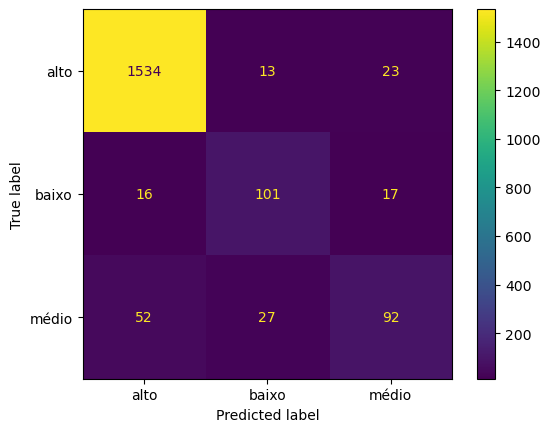

              precision    recall  f1-score   support

        alto       0.96      0.97      0.96      1552
       baixo       0.75      0.69      0.72       150
       médio       0.66      0.62      0.64       173

    accuracy                           0.91      1875
   macro avg       0.79      0.76      0.77      1875
weighted avg       0.91      0.91      0.91      1875



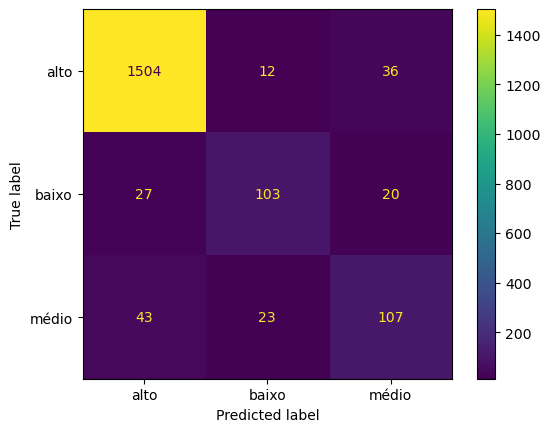

              precision    recall  f1-score   support

        alto       0.94      0.98      0.96      1531
       baixo       0.73      0.69      0.71       147
       médio       0.71      0.51      0.59       197

    accuracy                           0.91      1875
   macro avg       0.79      0.73      0.75      1875
weighted avg       0.90      0.91      0.90      1875



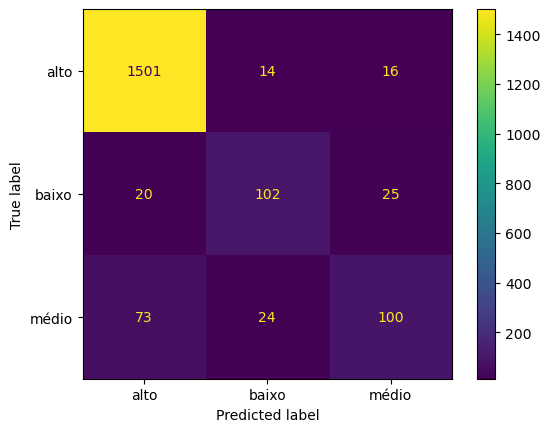

              precision    recall  f1-score   support

        alto       0.96      0.97      0.97      1531
       baixo       0.74      0.73      0.74       152
       médio       0.67      0.59      0.63       192

    accuracy                           0.91      1875
   macro avg       0.79      0.76      0.78      1875
weighted avg       0.91      0.91      0.91      1875



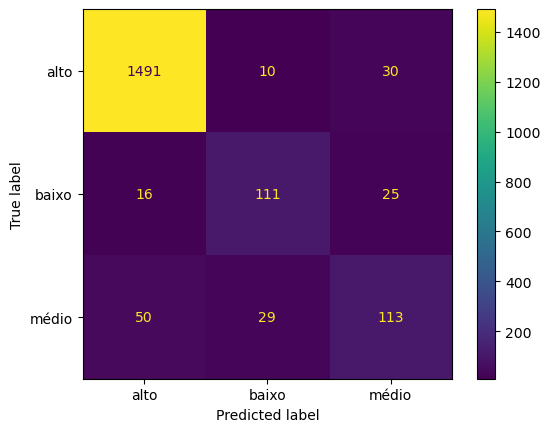

              precision    recall  f1-score   support

        alto       0.95      0.97      0.96      1546
       baixo       0.72      0.71      0.71       147
       médio       0.69      0.54      0.61       182

    accuracy                           0.91      1875
   macro avg       0.78      0.74      0.76      1875
weighted avg       0.90      0.91      0.91      1875



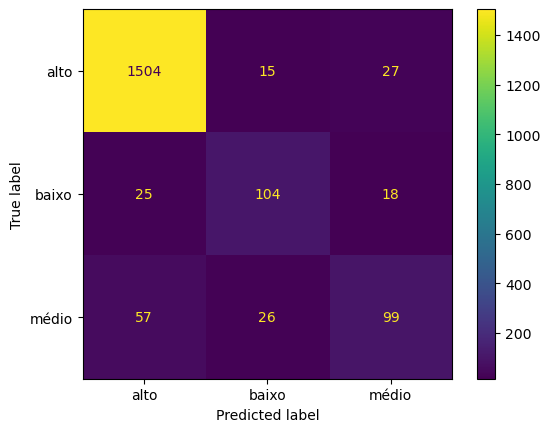

In [43]:

kf = KFold(n_splits=5)
kf.get_n_splits(X)

print(kf)
for train_index, test_index in kf.split(X):

  #divisao dos dados X, Y
  X_trainForest, X_testForest, Y_trainForest, Y_testForest = train_test_split(X, y)

  #normalizando os dados treino e teste
  scaler = StandardScaler()
  scaler.fit(X_trainForest)
  X_trainForest = scaler.transform(X_trainForest)
  X_testForest =scaler.transform(X_testForest)

  # Instânciando o objeto classificador:
  rf = RandomForestClassifier(n_estimators=200, criterion='log_loss', max_features=9, random_state=42)
  rf.fit(X_trainForest,Y_trainForest)

  # Treinando o modelo de arvore de decisão:
  y_predForest = rf.predict(X_testForest)

  #métricas de avaliação
  print(metrics.classification_report(Y_testForest,y_predForest))

  #Matriz de confusão SVM
  ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(Y_testForest, y_predForest), display_labels=rf.classes_).plot()
  plt.grid(False)
  plt.show()

## Extra Trees

In [44]:
# Dicionário com 3 possíveis valores para os principais hiperárâmetros de otimização do algoritmo
# Será usado posteriormente para serem avalizados por meio da otimização Bayesiana
parametros = {
    'n_estimators': (100, 200, 500),
    'min_samples_split': (2, 5, 10),
    'criterion': ('gini', 'entropy', 'log_loss'),
    'min_samples_leaf':(1, 3, 5),
    'max_features': ('sqrt', 5, 9)
}
X_tree = df[['DiaSemChuva', 'Precipitacao', 'Temp. Max. (C)', 'Temp. Min. (C)', 'Umi. Min. (%)', 'Pto Orvalho Max. (C)',
                                    'Pto Orvalho Min. (C)', 'Pressao Max. (hPa)', 'Pressao Min. (hPa)',
                                     'Dir. Vento (m/s)']]

X_train, X_test, y_train, y_test = train_test_split(X_tree, y, test_size=0.2, random_state=42)
bayes_search = BayesSearchCV(ExtraTreesClassifier(), parametros, n_iter=20, cv=5, scoring='accuracy', random_state=42)
bayes_search.fit(X_train, y_train)

print(bayes_search.best_params_)

OrderedDict({'criterion': 'log_loss', 'max_features': 9, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 500})


KFold(n_splits=5, random_state=None, shuffle=False)
              precision    recall  f1-score   support

        alto       0.97      0.98      0.98      1531
       baixo       0.86      0.84      0.85       168
       médio       0.77      0.73      0.75       176

    accuracy                           0.95      1875
   macro avg       0.87      0.85      0.86      1875
weighted avg       0.94      0.95      0.94      1875



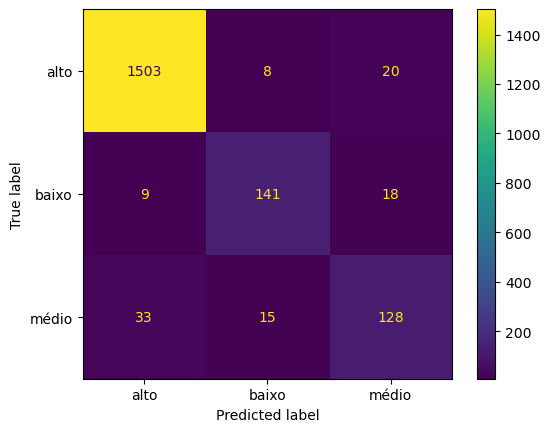

              precision    recall  f1-score   support

        alto       0.96      0.98      0.97      1545
       baixo       0.84      0.87      0.85       156
       médio       0.79      0.67      0.72       174

    accuracy                           0.94      1875
   macro avg       0.87      0.84      0.85      1875
weighted avg       0.94      0.94      0.94      1875



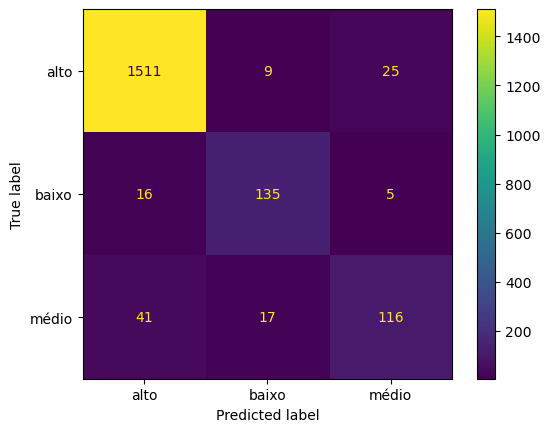

              precision    recall  f1-score   support

        alto       0.97      0.98      0.98      1564
       baixo       0.87      0.82      0.84       136
       médio       0.80      0.73      0.76       175

    accuracy                           0.95      1875
   macro avg       0.88      0.84      0.86      1875
weighted avg       0.95      0.95      0.95      1875



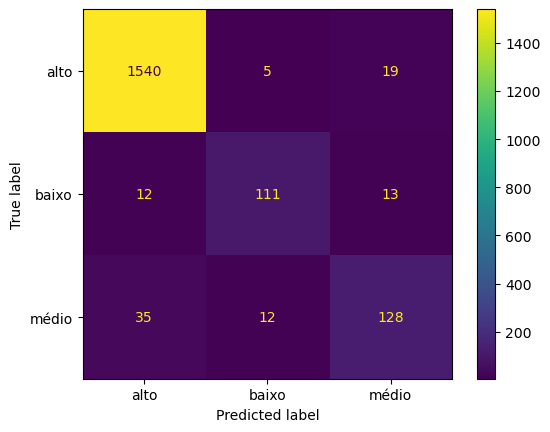

              precision    recall  f1-score   support

        alto       0.97      0.99      0.98      1547
       baixo       0.91      0.88      0.89       157
       médio       0.87      0.75      0.81       171

    accuracy                           0.96      1875
   macro avg       0.92      0.87      0.89      1875
weighted avg       0.96      0.96      0.96      1875



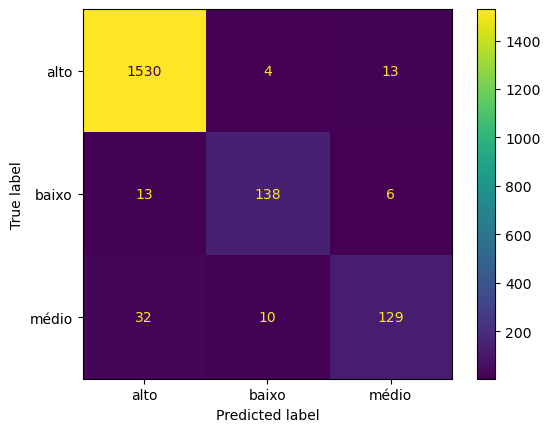

              precision    recall  f1-score   support

        alto       0.98      0.98      0.98      1560
       baixo       0.85      0.85      0.85       148
       médio       0.82      0.80      0.81       167

    accuracy                           0.96      1875
   macro avg       0.88      0.88      0.88      1875
weighted avg       0.96      0.96      0.96      1875



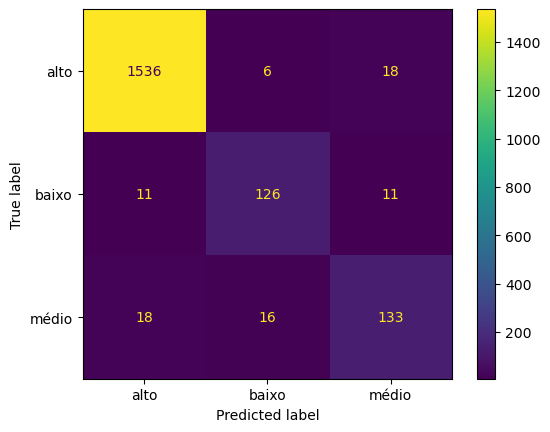

In [45]:
X = df[['DiaSemChuva', 'Precipitacao', 'Temp. Max. (C)', 'Temp. Min. (C)', 'Umi. Min. (%)', 'Pto Orvalho Max. (C)',
                                    'Pto Orvalho Min. (C)', 'Pressao Max. (hPa)', 'Pressao Min. (hPa)',
                                    'Vel. Vento (m/s)', 'Dir. Vento (m/s)', 'Raj. Vento (m/s)', ]]
y = df['ClassificacaoRF']

kf = KFold(n_splits=5)
kf.get_n_splits(X)

print(kf)
for train_index, test_index in kf.split(X):

  #divisao dos dados X, Y
  X_trainTREE, X_testTREE, Y_trainTREE, Y_testTREE = train_test_split(X, y)

  #normalizando os dados treino e teste
  scaler = StandardScaler()
  scaler.fit(X_trainTREE)
  X_trainTREE = scaler.transform(X_trainTREE)
  X_testTREE =scaler.transform(X_testTREE)

  # Instânciando o objeto classificador:
  et = ExtraTreesClassifier(criterion='log_loss', max_features= 9, n_estimators= 500, random_state=42)
  et.fit(X_trainTREE,Y_trainTREE)

  # Treinando o modelo de arvore de decisão:
  y_predTREE = rf.predict(X_testTREE)

  #métricas de avaliação
  print(metrics.classification_report(Y_testTREE,y_predTREE))

  #Matriz de confusão SVM
  ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(Y_testTREE, y_predTREE), display_labels=et.classes_).plot()
  plt.grid(False)
  plt.show()

### Examinando grau de importância dos atributos em Random Forest e Extra Trees

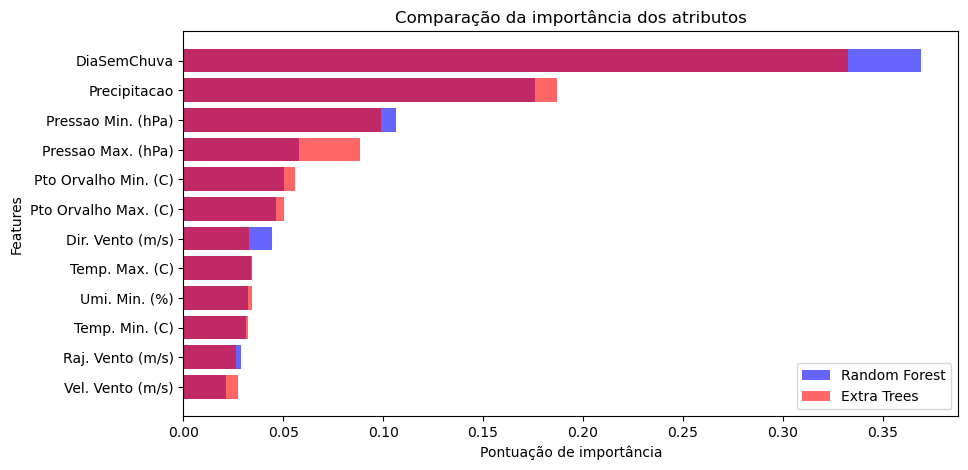

In [46]:
# Obter importância das features
rf_importances = rf.feature_importances_
et_importances = et.feature_importances_

# Criar um DataFrame para comparar
feature_names = X.columns
importance_df = pd.DataFrame({
    'Atributo': feature_names,
    'Random Forest': rf_importances,
    'Extra Trees': et_importances
}).sort_values(by='Random Forest', ascending=False)

# Plotar os resultados
plt.figure(figsize=(10, 5))
plt.barh(importance_df['Atributo'], importance_df['Random Forest'], color='blue', alpha=0.6, label='Random Forest')
plt.barh(importance_df['Atributo'], importance_df['Extra Trees'], color='red', alpha=0.6, label='Extra Trees')
plt.xlabel("Pontuação de importância")
plt.ylabel("Features")
plt.title("Comparação da importância dos atributos")
plt.legend()
plt.gca().invert_yaxis() 
plt.show()

In [47]:
importance_df

,Atributo,Random Forest,Extra Trees
0,DiaSemChuva,0.369394,0.332572
1,Precipitacao,0.176104,0.187174
8,Pressao Min. (hPa),0.106599,0.098677
7,Pressao Max. (hPa),0.058017,0.088442
6,Pto Orvalho Min. (C),0.050543,0.055908
5,Pto Orvalho Max. (C),0.046496,0.050535
10,Dir. Vento (m/s),0.044537,0.032745
2,Temp. Max. (C),0.034517,0.033889
4,Umi. Min. (%),0.032357,0.034193
3,Temp. Min. (C),0.031483,0.032206


A análise da importância dos atributos para os algortimos possibilitou perceber dois atributos em cada aloritmo que obteve pontuação menor que 0.03. No entanto, ao fazer o teste retirando os atributos para o treinamento, percebeu-se que não houve diferença significativa para a eficiência dos algoritmos.

## SVM

KFold(n_splits=5, random_state=None, shuffle=False)
              precision    recall  f1-score   support

        alto       0.90      0.98      0.94      1537
       baixo       0.55      0.51      0.53       141
       médio       0.50      0.22      0.30       197

    accuracy                           0.86      1875
   macro avg       0.65      0.57      0.59      1875
weighted avg       0.83      0.86      0.84      1875



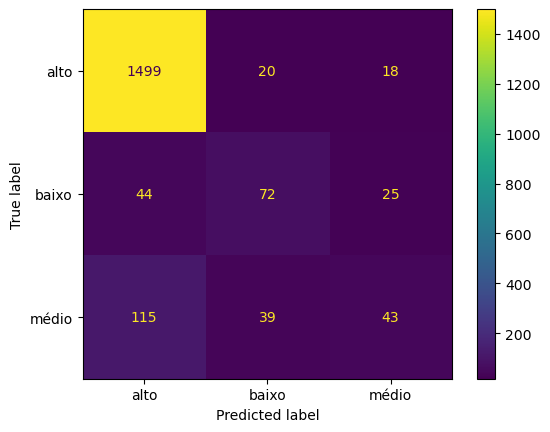

              precision    recall  f1-score   support

        alto       0.91      0.98      0.94      1550
       baixo       0.62      0.50      0.55       154
       médio       0.48      0.23      0.31       171

    accuracy                           0.87      1875
   macro avg       0.67      0.57      0.60      1875
weighted avg       0.84      0.87      0.85      1875



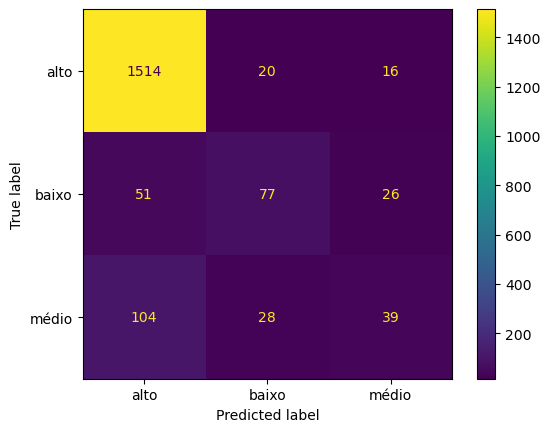

              precision    recall  f1-score   support

        alto       0.91      0.98      0.94      1557
       baixo       0.65      0.45      0.54       150
       médio       0.45      0.27      0.34       168

    accuracy                           0.87      1875
   macro avg       0.67      0.57      0.60      1875
weighted avg       0.85      0.87      0.85      1875



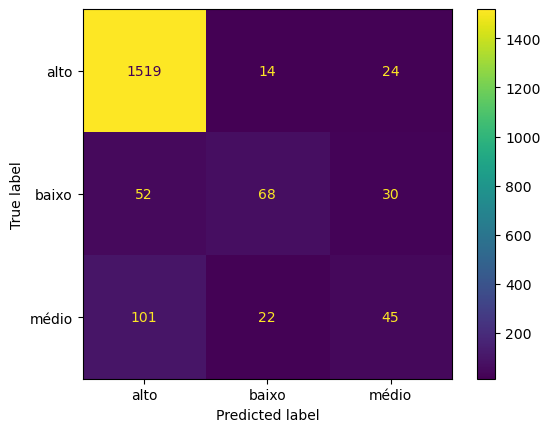

              precision    recall  f1-score   support

        alto       0.90      0.97      0.94      1552
       baixo       0.62      0.46      0.53       145
       médio       0.41      0.22      0.29       178

    accuracy                           0.86      1875
   macro avg       0.64      0.55      0.58      1875
weighted avg       0.83      0.86      0.84      1875



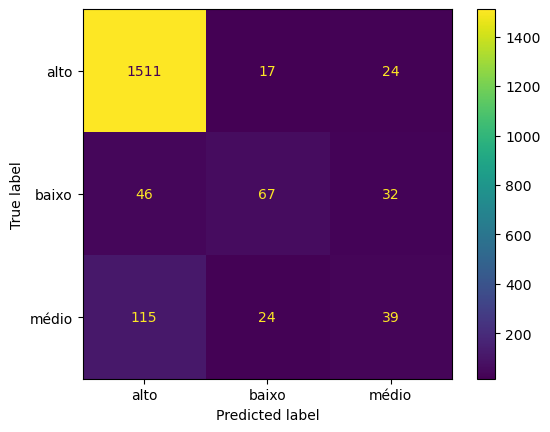

              precision    recall  f1-score   support

        alto       0.91      0.98      0.94      1552
       baixo       0.60      0.44      0.51       146
       médio       0.48      0.23      0.31       177

    accuracy                           0.87      1875
   macro avg       0.66      0.55      0.59      1875
weighted avg       0.84      0.87      0.85      1875



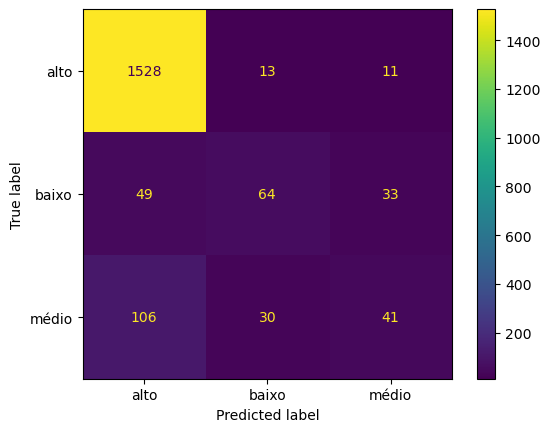

In [48]:
# Será utilizado os parâmetros default do SVM, por limitação computacional

X = df[['DiaSemChuva', 'Precipitacao', 'Temp. Max. (C)', 'Temp. Min. (C)', 'Umi. Min. (%)', 'Pto Orvalho Max. (C)',
                                    'Pto Orvalho Min. (C)', 'Pressao Max. (hPa)', 'Pressao Min. (hPa)',
                                    'Vel. Vento (m/s)', 'Dir. Vento (m/s)', 'Raj. Vento (m/s)', ]]
y = df['ClassificacaoRF']

kf = KFold(n_splits=5)
kf.get_n_splits(X)

print(kf)
for train_index, test_index in kf.split(X):

  #divisao dos dados X, Y
  X_trainSVM, X_testSVM, Y_trainSVM, Y_testSVM = train_test_split(X,y)

  #normalizando os dados treino e teste
  scaler = StandardScaler()
  scaler.fit(X_trainSVM)
  X_trainSVM =  scaler.transform(X_trainSVM)
  X_testSVM =scaler.transform(X_testSVM)

  #configuracao do classificador SVM
  clf = svm.SVC(kernel = 'rbf')
  clf.fit(X_trainSVM, Y_trainSVM)
  y_predSVM = clf.predict(X_testSVM)

  #métricas de avaliação
  print(metrics.classification_report(Y_testSVM,y_predSVM))
  from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

  #Matriz de confusão SVM
  ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(Y_testSVM, y_predSVM), display_labels=clf.classes_).plot()
  plt.grid(False)
  plt.show()

## KNN

In [54]:
# Dicionário com 3 possíveis valores para os principais hiperárâmetros de otimização do algoritmo
# Será usado posteriormente para serem avalizados por meio da otimização Bayesiana
parametros = {
    'n_neighbors': (3, 5, 7),
    'algorithm': ('auto', 'kd_tree', 'brute'),
}
from sklearn.neighbors import KNeighborsClassifier
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
bayes_search = BayesSearchCV(KNeighborsClassifier(), parametros, n_iter=20, cv=5, scoring='accuracy', random_state=42)
bayes_search.fit(X_train, y_train)

print(bayes_search.best_params_)

c:\Users\nicol\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point ['brute', 7] before, using random point ['auto', 3]
  warnings.warn(
c:\Users\nicol\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point ['brute', 3] before, using random point ['brute', 7]
  warnings.warn(
c:\Users\nicol\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point ['kd_tree', 7] before, using random point ['auto', 3]
  warnings.warn(
c:\Users\nicol\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point ['brute', 5] before, using random point ['auto', 3]
  warnings.warn(
c:\Users\nicol\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point ['auto', 7] before, using random point ['kd_tree', 3]
  warni

OrderedDict({'algorithm': 'auto', 'n_neighbors': 3})


KFold(n_splits=5, random_state=None, shuffle=False)
              precision    recall  f1-score   support

        alto       0.94      0.97      0.96      1549
       baixo       0.75      0.61      0.67       146
       médio       0.62      0.52      0.56       180

    accuracy                           0.90      1875
   macro avg       0.77      0.70      0.73      1875
weighted avg       0.89      0.90      0.90      1875



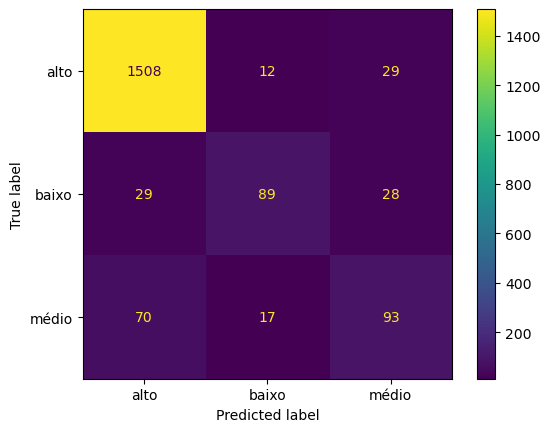

              precision    recall  f1-score   support

        alto       0.95      0.96      0.95      1544
       baixo       0.62      0.63      0.63       145
       médio       0.57      0.48      0.52       186

    accuracy                           0.89      1875
   macro avg       0.71      0.69      0.70      1875
weighted avg       0.88      0.89      0.89      1875



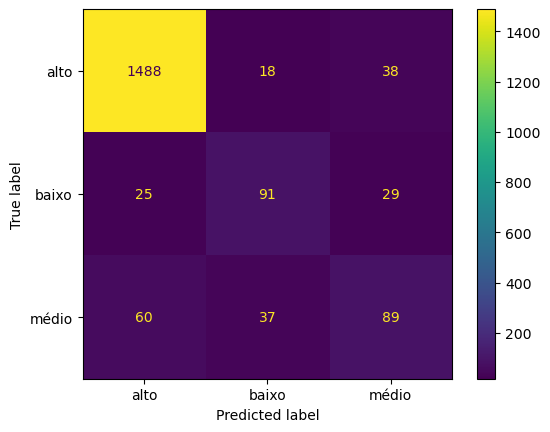

              precision    recall  f1-score   support

        alto       0.94      0.97      0.95      1550
       baixo       0.62      0.62      0.62       146
       médio       0.58      0.46      0.51       179

    accuracy                           0.89      1875
   macro avg       0.72      0.68      0.70      1875
weighted avg       0.88      0.89      0.89      1875



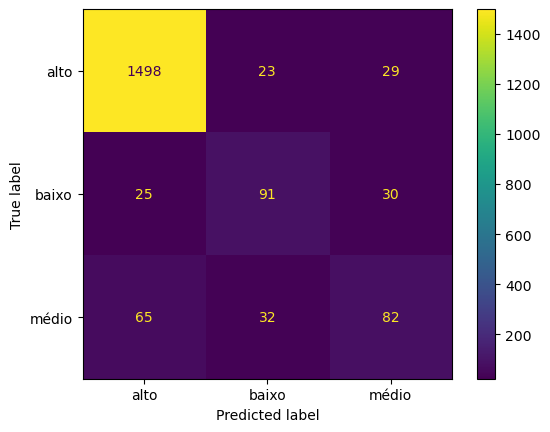

              precision    recall  f1-score   support

        alto       0.94      0.96      0.95      1562
       baixo       0.72      0.50      0.59       161
       médio       0.51      0.51      0.51       152

    accuracy                           0.89      1875
   macro avg       0.72      0.66      0.68      1875
weighted avg       0.88      0.89      0.88      1875



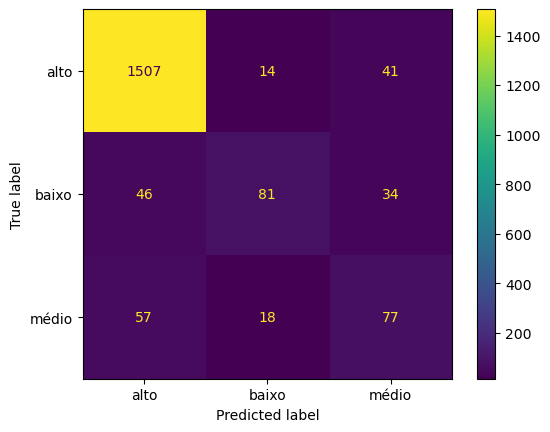

              precision    recall  f1-score   support

        alto       0.93      0.97      0.95      1550
       baixo       0.63      0.62      0.62       149
       médio       0.53      0.35      0.42       176

    accuracy                           0.88      1875
   macro avg       0.70      0.64      0.66      1875
weighted avg       0.87      0.88      0.87      1875



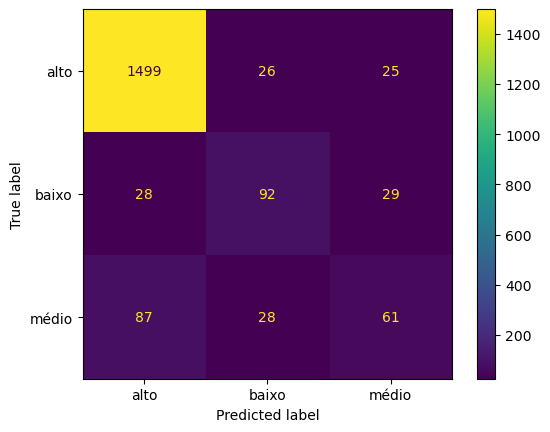

In [52]:
#Algoritmo KNN
kf = KFold(n_splits=5)
kf.get_n_splits(X)

print(kf)
for train_index, test_index in kf.split(X):

  #divisao dos dados X, Y
  X_trainKNN, X_testKNN, Y_trainKNN, Y_testKNN = train_test_split(X, y)

  #normalizando os dados treino e teste
  scaler = StandardScaler()
  scaler.fit(X_trainKNN)
  X_trainKNN =  scaler.transform(X_trainKNN)
  X_testKNN =scaler.transform(X_testKNN)

  from sklearn.neighbors import KNeighborsClassifier
  knn_classifier = KNeighborsClassifier(n_neighbors = 3)
  knn_classifier.fit(X_trainKNN, Y_trainKNN)
  y_predKNN = knn_classifier.predict(X_testKNN)

  #métricas de avaliação
  print(metrics.classification_report(Y_testKNN,y_predKNN))

  #Matriz de confusão SVM
  ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(Y_testKNN, y_predKNN), display_labels=knn_classifier.classes_).plot()
  plt.grid(False)
  plt.show()

In [ ]:
#a